# Energy-Based Models for Generative Modeling

## Tutorial: Mixed-Type Tabular Data Generation

In this tutorial, we'll learn how to build an Energy-Based Model (EBM) that can generate synthetic tabular data with both numerical and categorical features.

### What are Energy-Based Models?

Energy-Based Models define a probability distribution through an energy function $E(x; \theta)$:

$$p(x; \theta) = \frac{e^{-E(x; \theta)}}{Z(\theta)}$$

where:
- $E(x; \theta)$ is the energy function (lower energy = higher probability)
- $Z(\theta) = \int e^{-E(x; \theta)} dx$ is the partition function (intractable!)
- $\theta$ are the model parameters

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Step 1: Create a Synthetic Mixed-Type Dataset

We'll create a dataset with:
- **Numerical features**: Age, Income
- **Categorical features**: Education Level, Employment Status

In [2]:
# Create synthetic dataset
np.random.seed(42)
n_samples = 1000

# Numerical features
age = np.random.normal(35, 10, n_samples).clip(18, 65)
income = age * 1000 + np.random.normal(20000, 10000, n_samples)
income = income.clip(15000, 120000)

# Categorical features
education_levels = ['High School', 'Bachelor', 'Master', 'PhD']
education = np.random.choice(education_levels, n_samples, p=[0.3, 0.4, 0.2, 0.1])

employment_status = []
for i in range(n_samples):
    if age[i] < 25:
        status = np.random.choice(['Employed', 'Student', 'Unemployed'], p=[0.4, 0.5, 0.1])
    else:
        status = np.random.choice(['Employed', 'Student', 'Unemployed'], p=[0.8, 0.05, 0.15])
    employment_status.append(status)

# Create DataFrame
df = pd.DataFrame({
    'age': age,
    'income': income,
    'education': education,
    'employment': employment_status
})

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nSummary statistics:")
print(df.describe())

Dataset shape: (1000, 4)

First few rows:
         age        income    education employment
0  39.967142  73960.695896     Bachelor   Employed
1  33.617357  62863.693817  High School   Employed
2  41.476885  62073.189080     Bachelor    Student
3  50.230299  63760.930787  High School   Employed
4  32.658466  59640.699389       Master   Employed

Data types:
age           float64
income        float64
education      object
employment     object
dtype: object

Summary statistics:
               age         income
count  1000.000000    1000.000000
mean     35.310670   56019.052522
std       9.487970   13484.471999
min      18.000000   15000.000000
25%      28.524097   47773.412095
50%      35.253006   55428.021694
75%      41.479439   64430.262680
max      65.000000  102495.767432


## Step 2: Preprocess the Data

We need to:
1. Normalize numerical features
2. Encode categorical features as one-hot vectors

In [3]:
# Separate numerical and categorical features
numerical_cols = ['age', 'income']
categorical_cols = ['education', 'employment']

# Normalize numerical features
scaler = StandardScaler()
df_numerical = df[numerical_cols].copy()
df_numerical_scaled = scaler.fit_transform(df_numerical)

# One-hot encode categorical features
df_categorical = pd.get_dummies(df[categorical_cols], prefix=categorical_cols)

# Combine all features
X = np.concatenate([df_numerical_scaled, df_categorical.values], axis=1)
X_tensor = torch.FloatTensor(X).to(device)

print(f"Feature dimension: {X.shape[1]}")
print(f"Numerical features: {len(numerical_cols)}")
print(f"Categorical features (one-hot): {df_categorical.shape[1]}")
print(f"\nOne-hot columns: {list(df_categorical.columns)}")

Feature dimension: 9
Numerical features: 2
Categorical features (one-hot): 7

One-hot columns: ['education_Bachelor', 'education_High School', 'education_Master', 'education_PhD', 'employment_Employed', 'employment_Student', 'employment_Unemployed']


## Step 3: Define the Energy-Based Model

### Mathematical Foundation

The energy function is parameterized by a neural network:

$$E(x; \theta) = -f_\theta(x)$$

where $f_\theta$ is a neural network. The probability becomes:

$$p(x; \theta) = \frac{e^{f_\theta(x)}}{Z(\theta)}$$

### Training with Contrastive Divergence

Since $Z(\theta)$ is intractable, we use **Contrastive Divergence** to approximate the gradient:

$$\nabla_\theta \log p(x) = -\nabla_\theta E(x; \theta) - \mathbb{E}_{x' \sim p_\theta}[\nabla_\theta E(x'; \theta)]$$

The gradient has two terms:
1. **Positive phase**: Decrease energy of real data
2. **Negative phase**: Increase energy of generated samples

We approximate $\mathbb{E}_{x' \sim p_\theta}$ using **Langevin dynamics**.

In [4]:
class EnergyBasedModel(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32]):
        super(EnergyBasedModel, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.1)
            ])
            prev_dim = hidden_dim
        
        # Output layer: single energy value
        layers.append(nn.Linear(prev_dim, 1))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        # Returns negative energy (higher = more probable)
        return self.network(x).squeeze()

# Initialize model
input_dim = X.shape[1]
model = EnergyBasedModel(input_dim).to(device)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

EnergyBasedModel(
  (network): Sequential(
    (0): Linear(in_features=9, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)

Total parameters: 11649


## Step 4: Implement Langevin Dynamics Sampling

### Langevin MCMC

To sample from $p(x; \theta)$, we use Langevin dynamics:

$$x_{t+1} = x_t - \frac{\epsilon}{2} \nabla_x E(x_t; \theta) + \sqrt{\epsilon} \cdot z_t$$

where:
- $\epsilon$ is the step size
- $z_t \sim \mathcal{N}(0, I)$ is Gaussian noise
- $\nabla_x E(x_t; \theta)$ pushes samples toward low-energy regions

This creates a Markov chain that converges to $p(x; \theta)$.

In [5]:
def langevin_dynamics(model, x_init, n_steps=60, step_size=0.01, noise_scale=0.005):
    """
    Sample from the model using Langevin dynamics.
    
    Args:
        model: The energy-based model
        x_init: Initial samples [batch_size, input_dim]
        n_steps: Number of Langevin steps
        step_size: Step size for gradient descent
        noise_scale: Scale of Gaussian noise
    
    Returns:
        Final samples after n_steps
    """
    x = x_init.clone().detach().requires_grad_(True)
    
    for _ in range(n_steps):
        # Compute energy
        energy = -model(x).sum()  # Negative because model outputs negative energy
        
        # Compute gradient with respect to input
        grad = torch.autograd.grad(energy, x, create_graph=False)[0]
        
        # Langevin update
        with torch.no_grad():
            noise = torch.randn_like(x) * noise_scale
            x = x - step_size * grad + noise
            x.requires_grad_(True)
    
    return x.detach()

print("Langevin dynamics sampler defined successfully!")

Langevin dynamics sampler defined successfully!


## Step 5: Training Loop with Contrastive Divergence

### Training Algorithm

For each mini-batch:

1. **Positive phase**: Compute energy of real data
   $$\mathcal{L}_{pos} = \frac{1}{N}\sum_{i=1}^N E(x_i; \theta)$$

2. **Negative phase**: Generate samples using Langevin dynamics and compute their energy
   $$\mathcal{L}_{neg} = \frac{1}{N}\sum_{i=1}^N E(\tilde{x}_i; \theta)$$

3. **Total loss** (Contrastive Divergence):
   $$\mathcal{L} = \mathcal{L}_{pos} - \mathcal{L}_{neg}$$

We minimize this loss to:
- Decrease energy of real data
- Increase energy of generated (fake) samples

In [6]:
def train_ebm(model, X_train, n_epochs=100, batch_size=128, lr=0.0001):
    """
    Train the Energy-Based Model using Contrastive Divergence.
    """
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.0, 0.999))
    
    n_samples = X_train.shape[0]
    n_batches = n_samples // batch_size
    
    history = {'pos_energy': [], 'neg_energy': [], 'cd_loss': []}
    
    for epoch in range(n_epochs):
        # Shuffle data
        perm = torch.randperm(n_samples)
        X_shuffled = X_train[perm]
        
        epoch_pos_energy = 0
        epoch_neg_energy = 0
        epoch_cd_loss = 0
        
        for batch_idx in range(n_batches):
            # Get batch of real data
            batch_start = batch_idx * batch_size
            batch_end = batch_start + batch_size
            x_real = X_shuffled[batch_start:batch_end]
            
            # Positive phase: Energy of real data
            pos_energy = -model(x_real).mean()  # We want to minimize negative energy
            
            # Generate negative samples using Langevin dynamics
            x_fake_init = torch.randn_like(x_real) * 0.5
            x_fake = langevin_dynamics(model, x_fake_init, n_steps=60, step_size=0.01)
            
            # Negative phase: Energy of generated samples
            neg_energy = -model(x_fake).mean()
            
            # Contrastive Divergence loss
            cd_loss = pos_energy - neg_energy
            
            # Backpropagation
            optimizer.zero_grad()
            cd_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
            optimizer.step()
            
            # Track metrics
            epoch_pos_energy += pos_energy.item()
            epoch_neg_energy += neg_energy.item()
            epoch_cd_loss += cd_loss.item()
        
        # Average metrics
        epoch_pos_energy /= n_batches
        epoch_neg_energy /= n_batches
        epoch_cd_loss /= n_batches
        
        history['pos_energy'].append(epoch_pos_energy)
        history['neg_energy'].append(epoch_neg_energy)
        history['cd_loss'].append(epoch_cd_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}] | "
                  f"CD Loss: {epoch_cd_loss:.4f} | "
                  f"Pos Energy: {epoch_pos_energy:.4f} | "
                  f"Neg Energy: {epoch_neg_energy:.4f}")
    
    return history

In [7]:
# Train the model
print("Starting training...\n")
history = train_ebm(model, X_tensor, n_epochs=100, batch_size=128, lr=0.0001)
print("\nTraining complete!")

Starting training...

Epoch [10/100] | CD Loss: -0.1012 | Pos Energy: -0.1016 | Neg Energy: -0.0004
Epoch [20/100] | CD Loss: -0.2693 | Pos Energy: -0.2773 | Neg Energy: -0.0079
Epoch [30/100] | CD Loss: -0.4426 | Pos Energy: -0.5433 | Neg Energy: -0.1007
Epoch [40/100] | CD Loss: -0.4703 | Pos Energy: -0.9918 | Neg Energy: -0.5215
Epoch [50/100] | CD Loss: -0.4147 | Pos Energy: -1.5764 | Neg Energy: -1.1617
Epoch [60/100] | CD Loss: -0.3075 | Pos Energy: -1.9952 | Neg Energy: -1.6876
Epoch [70/100] | CD Loss: -0.2759 | Pos Energy: -2.2257 | Neg Energy: -1.9499
Epoch [80/100] | CD Loss: -0.2256 | Pos Energy: -2.3994 | Neg Energy: -2.1738
Epoch [90/100] | CD Loss: -0.1536 | Pos Energy: -2.5025 | Neg Energy: -2.3489
Epoch [100/100] | CD Loss: -0.1339 | Pos Energy: -2.5420 | Neg Energy: -2.4080

Training complete!


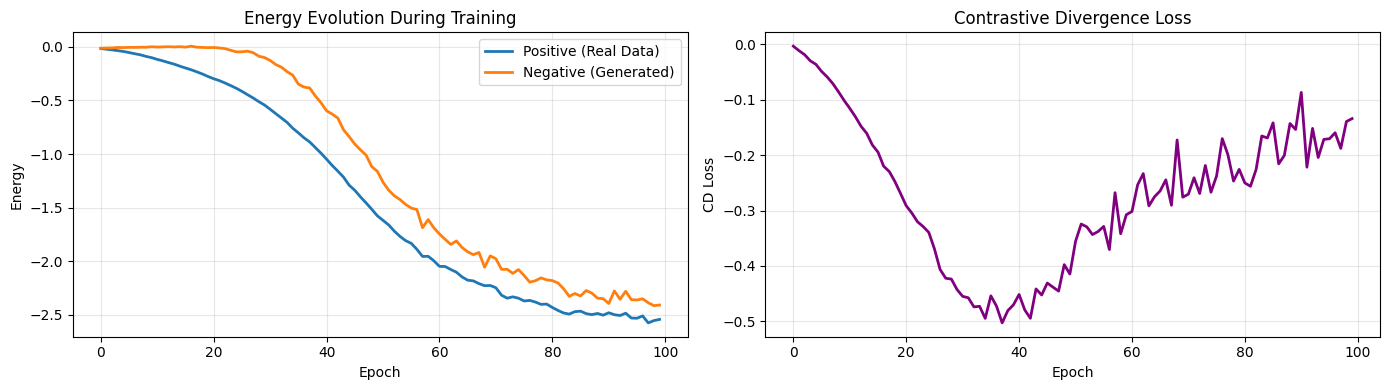

In [8]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Plot energies
axes[0].plot(history['pos_energy'], label='Positive (Real Data)', linewidth=2)
axes[0].plot(history['neg_energy'], label='Negative (Generated)', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Energy')
axes[0].set_title('Energy Evolution During Training')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot CD loss
axes[1].plot(history['cd_loss'], color='purple', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('CD Loss')
axes[1].set_title('Contrastive Divergence Loss')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 6: Generate New Samples

Now we can generate synthetic data by:
1. Starting from random noise
2. Running Langevin dynamics for many steps
3. Decoding the samples back to original format

In [9]:
def generate_samples(model, n_samples, input_dim, n_steps=200):
    """
    Generate new samples from the trained EBM.
    """
    model.eval()
    with torch.no_grad():
        # Start from random noise
        x_init = torch.randn(n_samples, input_dim).to(device) * 0.5
    
    # Run Langevin dynamics for more steps to get better samples
    x_generated = langevin_dynamics(model, x_init, n_steps=n_steps, step_size=0.01)
    
    return x_generated.cpu().numpy()

# Generate samples
n_generated = 500
generated_samples = generate_samples(model, n_generated, input_dim, n_steps=200)
print(f"Generated {n_generated} samples with shape {generated_samples.shape}")

Generated 500 samples with shape (500, 9)


## Step 7: Decode and Analyze Generated Samples

Convert the generated samples back to the original data format.

In [10]:
def decode_samples(samples, scaler, categorical_columns):
    """
    Decode generated samples back to original format.
    """
    # Split numerical and categorical
    n_numerical = 2  # age, income
    
    numerical_samples = samples[:, :n_numerical]
    categorical_samples = samples[:, n_numerical:]
    
    # Inverse transform numerical features
    numerical_decoded = scaler.inverse_transform(numerical_samples)
    
    # Decode categorical features (argmax of one-hot)
    categorical_decoded = []
    col_idx = 0
    
    # Education (4 categories)
    education_onehot = categorical_samples[:, col_idx:col_idx+4]
    education_indices = np.argmax(education_onehot, axis=1)
    education_decoded = [education_levels[i] for i in education_indices]
    col_idx += 4
    
    # Employment (3 categories)
    employment_onehot = categorical_samples[:, col_idx:col_idx+3]
    employment_indices = np.argmax(employment_onehot, axis=1)
    employment_levels = ['Employed', 'Student', 'Unemployed']
    employment_decoded = [employment_levels[i] for i in employment_indices]
    
    # Create DataFrame
    df_generated = pd.DataFrame({
        'age': numerical_decoded[:, 0],
        'income': numerical_decoded[:, 1],
        'education': education_decoded,
        'employment': employment_decoded
    })
    
    return df_generated

# Decode generated samples
df_generated = decode_samples(generated_samples, scaler, df_categorical.columns)

print("Generated samples:")
print(df_generated.head(10))
print("\nGenerated data statistics:")
print(df_generated.describe())

Generated samples:
         age        income    education employment
0  30.374243  54462.550781  High School   Employed
1  16.654499  29463.423828     Bachelor   Employed
2  59.473164  72430.906250  High School   Employed
3  60.271248  73999.968750     Bachelor   Employed
4  23.278826  31857.898438     Bachelor   Employed
5  65.451935  95242.445312  High School   Employed
6  62.348782  95682.195312  High School   Employed
7  53.381813  72270.015625     Bachelor   Employed
8  22.182886   4073.716553     Bachelor   Employed
9  52.490005  82549.750000  High School   Employed

Generated data statistics:
              age         income
count  500.000000     500.000000
mean    36.491196   55429.777344
std     20.382879   27020.839844
min      1.207715    4073.716553
25%     16.151114   28460.997070
50%     39.236700   60414.326172
75%     56.277343   81406.021484
max     73.363838  102137.617188


## Step 8: Compare Real vs. Generated Data

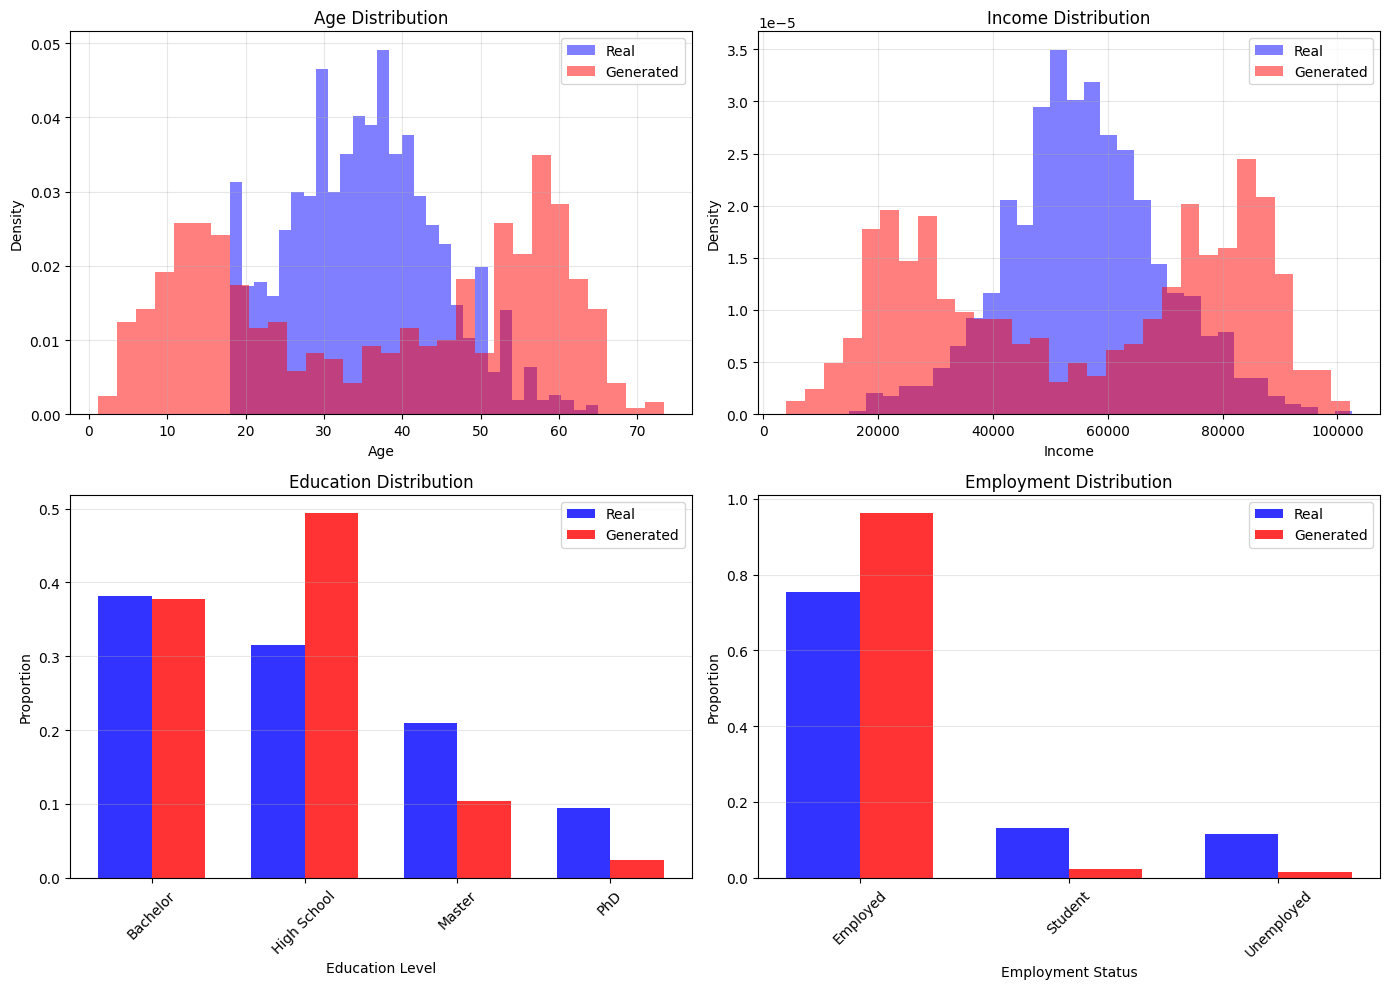

In [11]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Age distribution
axes[0, 0].hist(df['age'], bins=30, alpha=0.5, label='Real', density=True, color='blue')
axes[0, 0].hist(df_generated['age'], bins=30, alpha=0.5, label='Generated', density=True, color='red')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Age Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Income distribution
axes[0, 1].hist(df['income'], bins=30, alpha=0.5, label='Real', density=True, color='blue')
axes[0, 1].hist(df_generated['income'], bins=30, alpha=0.5, label='Generated', density=True, color='red')
axes[0, 1].set_xlabel('Income')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Income Distribution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Education distribution
education_real = df['education'].value_counts(normalize=True).sort_index()
education_gen = df_generated['education'].value_counts(normalize=True).reindex(education_real.index, fill_value=0)
x = np.arange(len(education_real))
width = 0.35
axes[1, 0].bar(x - width/2, education_real.values, width, label='Real', alpha=0.8, color='blue')
axes[1, 0].bar(x + width/2, education_gen.values, width, label='Generated', alpha=0.8, color='red')
axes[1, 0].set_xlabel('Education Level')
axes[1, 0].set_ylabel('Proportion')
axes[1, 0].set_title('Education Distribution')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(education_real.index, rotation=45)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Employment distribution
employment_real = df['employment'].value_counts(normalize=True).sort_index()
employment_gen = df_generated['employment'].value_counts(normalize=True).reindex(employment_real.index, fill_value=0)
x = np.arange(len(employment_real))
axes[1, 1].bar(x - width/2, employment_real.values, width, label='Real', alpha=0.8, color='blue')
axes[1, 1].bar(x + width/2, employment_gen.values, width, label='Generated', alpha=0.8, color='red')
axes[1, 1].set_xlabel('Employment Status')
axes[1, 1].set_ylabel('Proportion')
axes[1, 1].set_title('Employment Distribution')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(employment_real.index, rotation=45)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Step 9: Visualize Energy Landscape

Let's visualize how the energy function assigns probabilities to different data points.

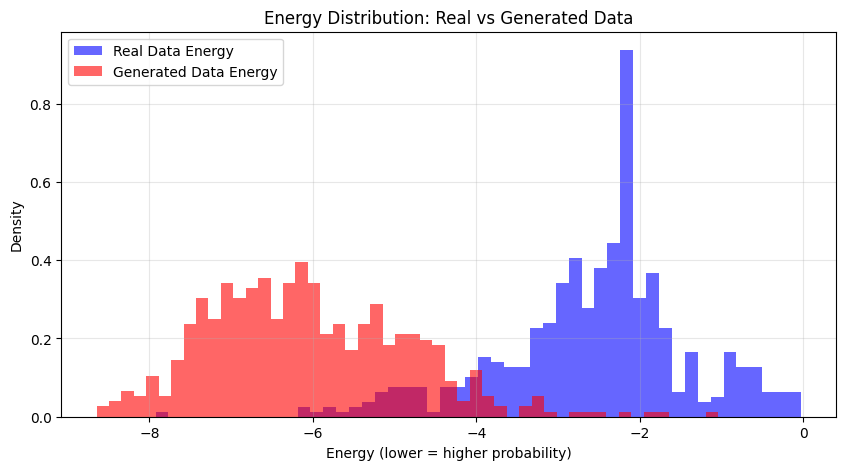

Real data average energy: -2.5669
Generated data average energy: -6.0497
Energy gap: 3.4828


In [12]:
# Compute energies for real and generated data
model.eval()
with torch.no_grad():
    real_energies = -model(X_tensor[:500]).cpu().numpy()
    gen_tensor = torch.FloatTensor(generated_samples[:500]).to(device)
    gen_energies = -model(gen_tensor).cpu().numpy()

# Plot energy distributions
plt.figure(figsize=(10, 5))
plt.hist(real_energies, bins=50, alpha=0.6, label='Real Data Energy', color='blue', density=True)
plt.hist(gen_energies, bins=50, alpha=0.6, label='Generated Data Energy', color='red', density=True)
plt.xlabel('Energy (lower = higher probability)')
plt.ylabel('Density')
plt.title('Energy Distribution: Real vs Generated Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Real data average energy: {real_energies.mean():.4f}")
print(f"Generated data average energy: {gen_energies.mean():.4f}")
print(f"Energy gap: {abs(real_energies.mean() - gen_energies.mean()):.4f}")

## Summary

### What We Learned:

1. **Energy-Based Models** define probability distributions implicitly through an energy function
2. **Contrastive Divergence** allows us to train EBMs without computing the intractable partition function
3. **Langevin Dynamics** enables sampling from the learned distribution
4. EBMs can handle **mixed-type data** (numerical + categorical) naturally

### Key Mathematical Concepts:

- **Energy function**: $p(x) \propto e^{-E(x)}$
- **Gradient-based sampling**: Langevin MCMC
- **Training objective**: Minimize CD loss = $E(x_{real}) - E(x_{fake})$

### Advantages of EBMs:
- Flexible architecture (any neural network)
- Can model complex dependencies
- Interpretable energy landscape

### Challenges:
- Slow sampling (requires many Langevin steps)
- Training can be unstable
- Requires careful hyperparameter tuning